In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./"))
import librosa
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew
import time
SAMPLE_RATE = 44100

from tqdm import tqdm
import scipy
data_path = './'
# ss = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

['dnnmult.py', 'Hybrid Multi-layer Derived.ipynb', 'CNN No_Hierarchy_torch.ipynb', 'model_40.pt', 'hierarchical_cnn.pt', '.DS_Store', 'CNN_Non_Hierarchical.pt', 'CNN No-Hierarchy OvA.ipynb', 'CNN No-Hierarchy_reproduce_new.ipynb', 'CNN Hierarchical reproduce.ipynb', 'CNN Multi-layer.ipynb', 'cnnmult.py', 'CNN No-Hierarchy.ipynb', 'SVM.ipynb', 'hybmulder.py', 'ablation_analysis.ipynb', 'Hybrid Multi-layer D+B.ipynb', 'model_h5', 'DNN_baseline.ipynb', 'DNN Multi-layer.ipynb', 'DNN No-Hierarchy.ipynb', '.ipynb_checkpoints', 'SVM No-Hierarchy OvA.ipynb', 'model_60.pt', 'DNN Quantized.ipynb', 'RNN', 'SVM', 'model_json', 'KNN', 'Feature Reduction Tests.ipynb', 'SVM No-Hierarchy.ipynb', 'mixd_mult.py', 'train_df.csv', 'Hybrid Multi-layer D+B No Prob.ipynb', 'load_blockwise.py', 'RFC', 'AUC-ROC Curve.ipynb', 'DNN', 'CNN', 'CNN No-Hierarchy_reproduce.ipynb']


In [2]:
#loading data
audio_train_files = os.listdir('../../ESC-50/audio/')
# audio_test_files = os.listdir('./audio_test')

train = pd.read_csv('../../ESC-50/meta/esc50.csv')
# submission = pd.read_csv('./sample_submission.csv')

In [3]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

#returns mfcc features with mean and standard deviation along time
def get_mfcc(name, path):
    b, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=80, lifter=140)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1), skew(gmm, axis = 1), np.median(gmm, axis = 1))))
    except:
        print('bad file')
        return pd.Series([0]*80)

In [4]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['filename']

s_time = time.time()
train_data = train_data['fname'].apply(get_mfcc, path='../../ESC-50/audio/')
print('done loading train mfcc')
e_time = time.time()
print(e_time - s_time)

train_data['fname'] = train['filename']
train_data['label'] = train['target']

done loading train mfcc
30.0800621509552


In [5]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,312,313,314,315,316,317,318,319,fname,label
0,-1495.460449,33.981899,-38.013977,-31.215279,-26.817242,2.695553,-23.469969,-3.666011,7.795646,5.667233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1-100032-A-0.wav,0
1,-654.925049,355.146790,-611.110352,225.396408,-352.620056,-179.832291,-444.408508,-245.108353,-175.657227,-291.888489,...,101.291237,86.527344,-78.399124,-63.001347,13.878695,-34.454124,-24.360683,-52.863365,1-100038-A-14.wav,14
2,-78.071724,424.462738,-230.804398,283.980255,-198.484894,132.904099,-101.119019,279.514099,-174.520752,314.197510,...,413.598877,-126.622719,21.310341,245.184769,-204.878479,-64.811729,137.173630,110.856163,1-100210-A-36.wav,36
3,-79.893417,431.904388,-246.030975,307.673462,-232.414139,190.786209,-127.077171,301.930725,-183.575775,273.924591,...,390.928833,-217.343948,179.023285,39.726002,-123.869400,-87.283493,123.348190,38.215591,1-100210-B-36.wav,36
4,-1199.333130,597.290466,131.056137,379.930908,26.223122,117.693100,-34.786598,1.109512,-134.291672,166.270142,...,164.559326,-216.147720,32.302731,-70.498199,93.890045,-60.953548,41.960548,-126.400230,1-101296-A-19.wav,19


In [6]:
#Features from LightGBM baseline kernel: https://www.kaggle.com/opanichev/lightgbm-baseline
# MAPk from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def extract_features(files, path):
    features = {}

    cnt = 0
    for f in tqdm(files):
        features[f] = {}

        fs, data = scipy.io.wavfile.read(os.path.join(path, f))

        abs_data = np.abs(data)
        diff_data = np.diff(data)

        def calc_part_features(data, n=2, prefix=''):
            f_i = 1
            for i in range(0, len(data), len(data)//n):
                features[f]['{}mean_{}_{}'.format(prefix, f_i, n)] = np.mean(data[i:i + len(data)//n])
                features[f]['{}std_{}_{}'.format(prefix, f_i, n)] = np.std(data[i:i + len(data)//n])
                features[f]['{}min_{}_{}'.format(prefix, f_i, n)] = np.min(data[i:i + len(data)//n])
                features[f]['{}max_{}_{}'.format(prefix, f_i, n)] = np.max(data[i:i + len(data)//n])

        features[f]['len'] = len(data)
        if features[f]['len'] > 0:
            n = 1
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 2
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 3
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')


        cnt += 1

        # if cnt >= 1000:
        #     break

    features = pd.DataFrame(features).T.reset_index()
    features.rename(columns={'index': 'fname'}, inplace=True)
    
    return features

path = "../../ESC-50/audio/"
train_files = train.filename.values
train_features = extract_features(train_files, path)

100%|██████████| 2000/2000 [00:19<00:00, 100.22it/s]


In [7]:
train_data = train_data.merge(train_features, on='fname', how='left')
train_data.to_csv("./train_df.csv")
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,min_1_3,max_1_3,abs_mean_1_3,abs_std_1_3,abs_min_1_3,abs_max_1_3,diff_mean_1_3,diff_std_1_3,diff_min_1_3,diff_max_1_3
0,-1495.460449,33.981899,-38.013977,-31.215279,-26.817242,2.695553,-23.469969,-3.666011,7.795646,5.667233,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,-654.925049,355.146790,-611.110352,225.396408,-352.620056,-179.832291,-444.408508,-245.108353,-175.657227,-291.888489,...,-5336.0,4553.0,783.556857,624.554197,0.0,5336.0,-1099.5,137.5,-1237.0,-962.0
2,-78.071724,424.462738,-230.804398,283.980255,-198.484894,132.904099,-101.119019,279.514099,-174.520752,314.197510,...,-32141.0,32767.0,7447.340422,5258.252535,0.0,32767.0,-8262.5,921.5,-9184.0,-7341.0
3,-79.893417,431.904388,-246.030975,307.673462,-232.414139,190.786209,-127.077171,301.930725,-183.575775,273.924591,...,-32768.0,32767.0,6052.735306,5143.856077,-32768.0,32767.0,-286.0,777.0,-1063.0,491.0
4,-1199.333130,597.290466,131.056137,379.930908,26.223122,117.693100,-34.786598,1.109512,-134.291672,166.270142,...,-1142.0,1049.0,158.945646,137.849542,0.0,1142.0,-26.0,5.0,-31.0,-21.0


In [8]:
#Functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
# Construct features set
train_data = pd.read_csv("./train_df.csv")
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)
rfc.fit(X_train, y_train)
#more functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
def proba2labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids
#checking the accuracy of the model
print(rfc.score(X_val, y_val))

0.61


In [10]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(358, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 50)
        self.norm1 = nn.BatchNorm1d(128)
        self.norm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [12]:
# load data:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class audiodata(Dataset):
    def __init__(self):
        
        self.data = pd.read_csv("./train_df.csv")
        X = self.data.drop(['label', 'fname'], axis=1)
        feature_names = list(X.columns)
        X = X.values
        labels = np.sort(np.unique(train_data.label.values))
        num_class = len(labels)
        c2i = {}
        i2c = {}
        for i, c in enumerate(labels):
            c2i[c] = i
            i2c[i] = c
        y = np.array([c2i[x] for x in train_data.label.values])
        
            
    
        self.data_list = X
        self.label_list = y
        
#         print(self.data_list)
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        
        data = self.data_list[index]
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label

data = audiodata()
# data.__getitem__(1)

2000 2000


In [13]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

model = Net()
print(model)
model = model#.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0000)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 2000
batch_size = 64

validation_split = .2
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset  = audiodata()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(400):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net(
  (fc1): Linear(in_features=358, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=50, bias=True)
  (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (softmax): Softmax(dim=None)
)
57842
2000 2000
===========Phase: Val============
Validation Time: 0.015420913696289062
Epoch: 0  val_loss: 3.9122420719691684
Epoch: 0  val_accuracy: 0.022321428571428572
===========Phase: Train============
Training Time: 0.7269413471221924
Epoch: 0  train_loss: 3.899496669769287
Epoch: 0  train_accuracy: 0.075

===========Phase: Val============
Validation Time: 0.016979217529296875
Epoch: 1  val_loss: 3.88563449042184
Epoch: 1  val_accuracy: 0.078125
===========Phase: Train============
Training Time: 0.1044318675994873
Epoch: 1  train_loss: 3.

===========Phase: Train============
Training Time: 0.09195876121520996
Epoch: 26  train_loss: 3.4252880668640135
Epoch: 26  train_accuracy: 0.556875

===========Phase: Val============
Validation Time: 0.012883663177490234
Epoch: 27  val_loss: 3.6267030920301164
Epoch: 27  val_accuracy: 0.3392857142857143
===========Phase: Train============
Training Time: 0.09017562866210938
Epoch: 27  train_loss: 3.4109550189971922
Epoch: 27  train_accuracy: 0.5675

===========Phase: Val============
Validation Time: 0.013384103775024414
Epoch: 28  val_loss: 3.608255590711321
Epoch: 28  val_accuracy: 0.36830357142857145
===========Phase: Train============
Training Time: 0.0913228988647461
Epoch: 28  train_loss: 3.402401943206787
Epoch: 28  train_accuracy: 0.58375

===========Phase: Val============
Validation Time: 0.013456583023071289
Epoch: 29  val_loss: 3.6151979310171947
Epoch: 29  val_accuracy: 0.359375
===========Phase: Train============
Training Time: 0.08989906311035156
Epoch: 29  train_loss: 3.3

===========Phase: Train============
Training Time: 0.10597753524780273
Epoch: 54  train_loss: 3.2102944469451904
Epoch: 54  train_accuracy: 0.75625

===========Phase: Val============
Validation Time: 0.015054464340209961
Epoch: 55  val_loss: 3.53840126310076
Epoch: 55  val_accuracy: 0.453125
===========Phase: Train============
Training Time: 0.09087157249450684
Epoch: 55  train_loss: 3.1991575145721436
Epoch: 55  train_accuracy: 0.769375

===========Phase: Val============
Validation Time: 0.013288259506225586
Epoch: 56  val_loss: 3.552852290017264
Epoch: 56  val_accuracy: 0.42410714285714285
===========Phase: Train============
Training Time: 0.09335994720458984
Epoch: 56  train_loss: 3.2000304889678954
Epoch: 56  train_accuracy: 0.771875

===========Phase: Val============
Validation Time: 0.013335943222045898
Epoch: 57  val_loss: 3.513630287987845
Epoch: 57  val_accuracy: 0.47098214285714285
===========Phase: Train============
Training Time: 0.09981155395507812
Epoch: 57  train_loss: 3

===========Phase: Train============
Training Time: 0.09435534477233887
Epoch: 82  train_loss: 3.13331485748291
Epoch: 82  train_accuracy: 0.83375

===========Phase: Val============
Validation Time: 0.01402139663696289
Epoch: 83  val_loss: 3.507741246904646
Epoch: 83  val_accuracy: 0.4732142857142857
===========Phase: Train============
Training Time: 0.09689879417419434
Epoch: 83  train_loss: 3.1279172801971438
Epoch: 83  train_accuracy: 0.8375

===========Phase: Val============
Validation Time: 0.013452529907226562
Epoch: 84  val_loss: 3.5178147043500627
Epoch: 84  val_accuracy: 0.45982142857142855
===========Phase: Train============
Training Time: 0.09505224227905273
Epoch: 84  train_loss: 3.120279521942139
Epoch: 84  train_accuracy: 0.850625

===========Phase: Val============
Validation Time: 0.014723062515258789
Epoch: 85  val_loss: 3.5132929256984164
Epoch: 85  val_accuracy: 0.45535714285714285
===========Phase: Train============
Training Time: 0.11891555786132812
Epoch: 85  train_

===========Phase: Train============
Training Time: 0.09285354614257812
Epoch: 110  train_loss: 3.054219264984131
Epoch: 110  train_accuracy: 0.90625

===========Phase: Val============
Validation Time: 0.012766361236572266
Epoch: 111  val_loss: 3.4893078804016113
Epoch: 111  val_accuracy: 0.49330357142857145
===========Phase: Train============
Training Time: 0.09699249267578125
Epoch: 111  train_loss: 3.0542895126342775
Epoch: 111  train_accuracy: 0.90625

===========Phase: Val============
Validation Time: 0.012829780578613281
Epoch: 112  val_loss: 3.482978548322405
Epoch: 112  val_accuracy: 0.48660714285714285
===========Phase: Train============
Training Time: 0.09166955947875977
Epoch: 112  train_loss: 3.0516384410858155
Epoch: 112  train_accuracy: 0.908125

===========Phase: Val============
Validation Time: 0.013421773910522461
Epoch: 113  val_loss: 3.471728903906686
Epoch: 113  val_accuracy: 0.5
===========Phase: Train============
Training Time: 0.09220457077026367
Epoch: 113  train

===========Phase: Train============
Training Time: 0.09297299385070801
Epoch: 138  train_loss: 3.0430045890808106
Epoch: 138  train_accuracy: 0.91375

===========Phase: Val============
Validation Time: 0.012963533401489258
Epoch: 139  val_loss: 3.4780054092407227
Epoch: 139  val_accuracy: 0.5178571428571429
===========Phase: Train============
Training Time: 0.0907745361328125
Epoch: 139  train_loss: 3.041544599533081
Epoch: 139  train_accuracy: 0.914375

===========Phase: Val============
Validation Time: 0.012929201126098633
Epoch: 140  val_loss: 3.471841471535819
Epoch: 140  val_accuracy: 0.49330357142857145
===========Phase: Train============
Training Time: 0.09307146072387695
Epoch: 140  train_loss: 3.039845571517944
Epoch: 140  train_accuracy: 0.915625

===========Phase: Val============
Validation Time: 0.012957096099853516
Epoch: 141  val_loss: 3.4690074580056325
Epoch: 141  val_accuracy: 0.5044642857142857
===========Phase: Train============
Training Time: 0.08931469917297363
Epo

===========Phase: Train============
Training Time: 0.09031343460083008
Epoch: 166  train_loss: 3.031322536468506
Epoch: 166  train_accuracy: 0.92

===========Phase: Val============
Validation Time: 0.013675928115844727
Epoch: 167  val_loss: 3.4860706669943675
Epoch: 167  val_accuracy: 0.47767857142857145
===========Phase: Train============
Training Time: 0.08743834495544434
Epoch: 167  train_loss: 3.032005958557129
Epoch: 167  train_accuracy: 0.92

===========Phase: Val============
Validation Time: 0.013180732727050781
Epoch: 168  val_loss: 3.439147812979562
Epoch: 168  val_accuracy: 0.5290178571428571
===========Phase: Train============
Training Time: 0.09135866165161133
Epoch: 168  train_loss: 3.0322452068328856
Epoch: 168  train_accuracy: 0.919375

===========Phase: Val============
Validation Time: 0.013015985488891602
Epoch: 169  val_loss: 3.4574492318289622
Epoch: 169  val_accuracy: 0.5022321428571429
===========Phase: Train============
Training Time: 0.09298205375671387
Epoch: 16

===========Phase: Train============
Training Time: 0.09318423271179199
Epoch: 194  train_loss: 3.027470407485962
Epoch: 194  train_accuracy: 0.923125

===========Phase: Val============
Validation Time: 0.013672351837158203
Epoch: 195  val_loss: 3.468599728175572
Epoch: 195  val_accuracy: 0.515625
===========Phase: Train============
Training Time: 0.0884714126586914
Epoch: 195  train_loss: 3.027694511413574
Epoch: 195  train_accuracy: 0.923125

===========Phase: Val============
Validation Time: 0.012592077255249023
Epoch: 196  val_loss: 3.4791177681514194
Epoch: 196  val_accuracy: 0.5022321428571429
===========Phase: Train============
Training Time: 0.09224843978881836
Epoch: 196  train_loss: 3.026301832199097
Epoch: 196  train_accuracy: 0.925

===========Phase: Val============
Validation Time: 0.012792587280273438
Epoch: 197  val_loss: 3.466780492237636
Epoch: 197  val_accuracy: 0.5178571428571429
===========Phase: Train============
Training Time: 0.08922290802001953
Epoch: 197  train_

===========Phase: Train============
Training Time: 0.08917379379272461
Epoch: 222  train_loss: 3.018635187149048
Epoch: 222  train_accuracy: 0.931875

===========Phase: Val============
Validation Time: 0.012314081192016602
Epoch: 223  val_loss: 3.4575001171657016
Epoch: 223  val_accuracy: 0.5133928571428571
===========Phase: Train============
Training Time: 0.09415483474731445
Epoch: 223  train_loss: 3.019742069244385
Epoch: 223  train_accuracy: 0.931875

===========Phase: Val============
Validation Time: 0.01295781135559082
Epoch: 224  val_loss: 3.475067819867815
Epoch: 224  val_accuracy: 0.49776785714285715
===========Phase: Train============
Training Time: 0.10099339485168457
Epoch: 224  train_loss: 3.0193936347961428
Epoch: 224  train_accuracy: 0.9325

===========Phase: Val============
Validation Time: 0.01465153694152832
Epoch: 225  val_loss: 3.4631727082388744
Epoch: 225  val_accuracy: 0.5357142857142857
===========Phase: Train============
Training Time: 0.10113668441772461
Epoch

===========Phase: Train============
Training Time: 0.09649229049682617
Epoch: 250  train_loss: 3.015676250457764
Epoch: 250  train_accuracy: 0.935625

===========Phase: Val============
Validation Time: 0.013961315155029297
Epoch: 251  val_loss: 3.4663404737200056
Epoch: 251  val_accuracy: 0.515625
===========Phase: Train============
Training Time: 0.09061908721923828
Epoch: 251  train_loss: 3.014350833892822
Epoch: 251  train_accuracy: 0.93625

===========Phase: Val============
Validation Time: 0.013214111328125
Epoch: 252  val_loss: 3.4462182181222096
Epoch: 252  val_accuracy: 0.515625
===========Phase: Train============
Training Time: 0.09589624404907227
Epoch: 252  train_loss: 3.0144357585906985
Epoch: 252  train_accuracy: 0.93625

===========Phase: Val============
Validation Time: 0.013700723648071289
Epoch: 253  val_loss: 3.478499412536621
Epoch: 253  val_accuracy: 0.4888392857142857
===========Phase: Train============
Training Time: 0.09300017356872559
Epoch: 253  train_loss: 3.0

===========Phase: Train============
Training Time: 0.09096121788024902
Epoch: 278  train_loss: 3.0127321910858154
Epoch: 278  train_accuracy: 0.939375

===========Phase: Val============
Validation Time: 0.01373744010925293
Epoch: 279  val_loss: 3.4801721572875977
Epoch: 279  val_accuracy: 0.49330357142857145
===========Phase: Train============
Training Time: 0.0938103199005127
Epoch: 279  train_loss: 3.0133803367614744
Epoch: 279  train_accuracy: 0.938125

===========Phase: Val============
Validation Time: 0.01750802993774414
Epoch: 280  val_loss: 3.466841765812465
Epoch: 280  val_accuracy: 0.5111607142857143
===========Phase: Train============
Training Time: 0.1074533462524414
Epoch: 280  train_loss: 3.0124351501464846
Epoch: 280  train_accuracy: 0.93875

===========Phase: Val============
Validation Time: 0.013497114181518555
Epoch: 281  val_loss: 3.4509832518441335
Epoch: 281  val_accuracy: 0.5133928571428571
===========Phase: Train============
Training Time: 0.09230566024780273
Epoc

===========Phase: Train============
Training Time: 0.08996701240539551
Epoch: 306  train_loss: 3.0106807804107665
Epoch: 306  train_accuracy: 0.94

===========Phase: Val============
Validation Time: 0.0132598876953125
Epoch: 307  val_loss: 3.4693377017974854
Epoch: 307  val_accuracy: 0.5022321428571429
===========Phase: Train============
Training Time: 0.0873723030090332
Epoch: 307  train_loss: 3.0102844715118406
Epoch: 307  train_accuracy: 0.94

===========Phase: Val============
Validation Time: 0.01280355453491211
Epoch: 308  val_loss: 3.4548351083483015
Epoch: 308  val_accuracy: 0.5044642857142857
===========Phase: Train============
Training Time: 0.09092879295349121
Epoch: 308  train_loss: 3.01013032913208
Epoch: 308  train_accuracy: 0.940625

===========Phase: Val============
Validation Time: 0.012822151184082031
Epoch: 309  val_loss: 3.4787585054125105
Epoch: 309  val_accuracy: 0.48660714285714285
===========Phase: Train============
Training Time: 0.08967900276184082
Epoch: 309  

===========Phase: Train============
Training Time: 0.09279704093933105
Epoch: 334  train_loss: 3.0100038719177244
Epoch: 334  train_accuracy: 0.940625

===========Phase: Val============
Validation Time: 0.012972593307495117
Epoch: 335  val_loss: 3.4744724205562045
Epoch: 335  val_accuracy: 0.4888392857142857
===========Phase: Train============
Training Time: 0.09401702880859375
Epoch: 335  train_loss: 3.0106304836273194
Epoch: 335  train_accuracy: 0.94

===========Phase: Val============
Validation Time: 0.013065814971923828
Epoch: 336  val_loss: 3.4598502772194997
Epoch: 336  val_accuracy: 0.5089285714285714
===========Phase: Train============
Training Time: 0.09604477882385254
Epoch: 336  train_loss: 3.009956512451172
Epoch: 336  train_accuracy: 0.94125

===========Phase: Val============
Validation Time: 0.017450571060180664
Epoch: 337  val_loss: 3.444241694041661
Epoch: 337  val_accuracy: 0.5513392857142857
===========Phase: Train============
Training Time: 0.09407877922058105
Epoch:

===========Phase: Train============
Training Time: 0.09043264389038086
Epoch: 362  train_loss: 3.0091635513305666
Epoch: 362  train_accuracy: 0.94125

===========Phase: Val============
Validation Time: 0.012650489807128906
Epoch: 363  val_loss: 3.4554037366594588
Epoch: 363  val_accuracy: 0.5133928571428571
===========Phase: Train============
Training Time: 0.09000802040100098
Epoch: 363  train_loss: 3.009657745361328
Epoch: 363  train_accuracy: 0.940625

===========Phase: Val============
Validation Time: 0.013063430786132812
Epoch: 364  val_loss: 3.445526054927281
Epoch: 364  val_accuracy: 0.5334821428571429
===========Phase: Train============
Training Time: 0.09135985374450684
Epoch: 364  train_loss: 3.009380159378052
Epoch: 364  train_accuracy: 0.94125

===========Phase: Val============
Validation Time: 0.012616395950317383
Epoch: 365  val_loss: 3.4779557159968784
Epoch: 365  val_accuracy: 0.5066964285714286
===========Phase: Train============
Training Time: 0.10863876342773438
Epoc

===========Phase: Train============
Training Time: 0.08958697319030762
Epoch: 390  train_loss: 3.0089511394500734
Epoch: 390  train_accuracy: 0.941875

===========Phase: Val============
Validation Time: 0.012961387634277344
Epoch: 391  val_loss: 3.4487265178135464
Epoch: 391  val_accuracy: 0.5178571428571429
===========Phase: Train============
Training Time: 0.09058833122253418
Epoch: 391  train_loss: 3.008765058517456
Epoch: 391  train_accuracy: 0.941875

===========Phase: Val============
Validation Time: 0.013077974319458008
Epoch: 392  val_loss: 3.4538125651223317
Epoch: 392  val_accuracy: 0.5223214285714286
===========Phase: Train============
Training Time: 0.08858823776245117
Epoch: 392  train_loss: 3.0087713241577148
Epoch: 392  train_accuracy: 0.941875

===========Phase: Val============
Validation Time: 0.012724876403808594
Epoch: 393  val_loss: 3.457566295351301
Epoch: 393  val_accuracy: 0.5200892857142857
===========Phase: Train============
Training Time: 0.0926361083984375
Ep

In [14]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,400)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

<Figure size 640x480 with 2 Axes>

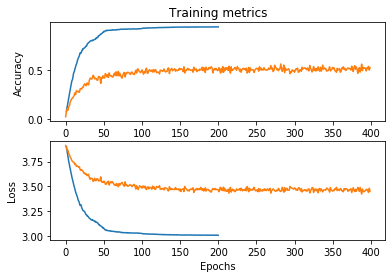

In [15]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,400)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()